In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import data_processing as dp
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier


warnings.filterwarnings("ignore")

data = arff.loadarff("../../data/3year.arff")
df = pd.DataFrame(data[0])
df_origin = df.copy()

In [26]:
X_smote, X_test, y_smote, y_test = dp.pre_process(df)

In [27]:
##1. anova
def KNN_anova(X_train,X_test,y_train,y_test):
    knn = KNeighborsClassifier(n_neighbors=5)

    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    
    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train,y_pred_train)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return train_accuracy,test_accuracy

Best k for train_accuracy: 30
Best k for test_accuracy: 27


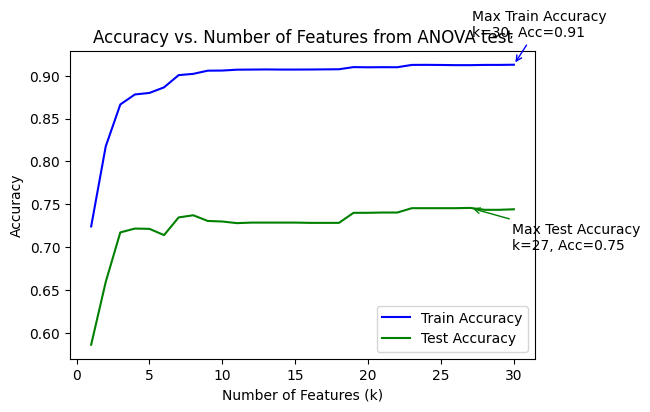

(         Attr29    Attr63    Attr24    Attr48    Attr33    Attr55    Attr36  \
 0      0.396077  0.000687  0.252086  0.270426  0.001175  0.181335  0.009412   
 1      0.459574  0.001888  0.255907  0.278044  0.001680  0.182337  0.011841   
 2      0.350609  0.002803  0.253041  0.271485  0.002629  0.181959  0.021547   
 3      0.327540  0.001921  0.252756  0.271702  0.002002  0.181901  0.011452   
 4      0.361823  0.001758  0.253098  0.272009  0.001889  0.181968  0.014372   
 ...         ...       ...       ...       ...       ...       ...       ...   
 13973  0.347861  0.002940  0.253059  0.272586  0.002678  0.181925  0.018222   
 13974  0.442719  0.001591  0.253012  0.272608  0.001815  0.182257  0.014159   
 13975  0.428601  0.002894  0.252952  0.271522  0.002710  0.181303  0.024621   
 13976  0.372259  0.006413  0.253878  0.275663  0.005097  0.182085  0.041716   
 13977  0.533448  0.001928  0.255565  0.272894  0.001527  0.191575  0.004738   
 
          Attr51    Attr61    Attr59  

In [28]:
dp.find_best_k_features_from_ANOVA(KNN_anova,X_smote,X_test,y_smote,y_test)

In [29]:
##2. bagging
from sklearn.ensemble import BaggingClassifier

def KNN_bagging(X_train,X_test,y_train,y_test,k,n):
    knn = KNeighborsClassifier(n_neighbors=k)

    # Initialize the Bagging classifier with k-NN as the base estimator
    bagging_knn = BaggingClassifier(knn, n_estimators=n, random_state=42)

    bagging_knn.fit(X_train,y_train)

    y_pred = bagging_knn.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return pd.Series({"accuracy":accuracy,"precision":precision,"recall":recall,"f1":f1})

KNN_bagging(X_smote,X_test,y_smote,y_test,5,10)
# only improve abit like 0.01

accuracy     0.747699
precision    0.055182
recall       0.305970
f1           0.093501
dtype: float64

In [30]:
def find_optimal_estimator(metric,a,b):
    max_n = 0
    max_met = 0
    for n in range(a,b):
        curr_met = KNN_bagging(X_smote,X_test,y_smote,y_test,5,n)[metric]
        if curr_met > max_met:
            max_met = curr_met
            max_n = n
    return max_n, max_met

find_optimal_estimator("f1",10,50)

(15, 0.096)

In [31]:
from sklearn.model_selection import cross_val_score

X  = pd.concat([X_smote,X_test])
y  = pd.concat([y_smote,y_test])

def knn_k_fold_f1(X, y, k_neighbor, k):
    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)

    # Perform k-fold cross-validation (let's use k=5)
    k_fold = k
    # Calculate F1 scores for each fold
    f1_scores = cross_val_score(knn, X, y, cv=k_fold, scoring="f1")

    # Get the index of the best F1 score
    best_f1_index = np.argmax(f1_scores)
    best_f1_score = f1_scores[best_f1_index]

    # Train a new model using the entire dataset
    final_model = KNeighborsClassifier(n_neighbors=k_neighbor)
    final_model.fit(X, y)

    return final_model, best_f1_score

final_model_f1, best_f1_score = knn_k_fold_f1(X, y, 5, 5)
print("Best F1 score:", best_f1_score)
y_pred_kfold_f1 = final_model_f1.predict(X_test)
f1_k_fold = f1_score(y_test, y_pred_kfold_f1)
print(f1_k_fold)


Best F1 score: 0.8666666666666667
0.13693693693693693


In [32]:
from sklearn.model_selection import GridSearchCV

def optimize_k_neighbors(X, y, k_neighbors):
    # Define the parameter grid
    param_grid = {'n_neighbors': k_neighbors}

    # Initialize the KNN classifier
    knn = KNeighborsClassifier()

    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1')

    # Fit the grid search to the data
    grid_search.fit(X, y)

    # Get the best estimator and best score
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    return best_estimator, best_score, best_params

# Define the range of k_neighbors values to try
k_neighbors = range(1, 21)

# Optimize k_neighbors
best_knn_model, best_f1_score, best_params = optimize_k_neighbors(X, y, k_neighbors)

print("Best k_neighbors:", best_params['n_neighbors'])
print("Best F1 score:", best_f1_score)
y_pred_kfold_k = best_knn_model.predict(X_test)

accuracy_kfold_k = accuracy_score(y_test, y_pred_kfold_k)
precision_kfold_k = precision_score(y_test, y_pred_kfold_k)
recall_kfold_k = recall_score(y_test, y_pred_kfold_k)
f1_kfold_k = f1_score(y_test, y_pred_kfold_k)

print(f"Accuracy = {accuracy_kfold_k}")
print(f"precision = {precision_kfold_k}")
print(f"recall = {recall_kfold_k}")
print(f"f1 = {f1_kfold_k}")

Best k_neighbors: 2
Best F1 score: 0.8944316077621377
Accuracy = 0.9657251666137734
precision = 1.0
recall = 0.19402985074626866
f1 = 0.325


In [58]:
#4. PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix

def pca(X_train,X_test,y_train,y_test,n):
    X  = pd.concat([X_train,X_test])
    y  = pd.concat([y_train,y_test])

    # Standardize the feature matrix
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA with desired number of components
    pca = PCA(n_components=n)

    # Apply PCA to the standardized feature matrix
    X_pca = pca.fit_transform(X_scaled)
    columns = [f'PC{i+1}' for i in range(n)]  # Column names for components
    X_pca_df = pd.DataFrame(X_pca, columns=columns)
    X_smote_pca = X_pca_df.iloc[:13978,:]
    X_test_pca = X_pca_df.iloc[13978:,:]
    return X_smote_pca,X_test_pca
    
# Now X_pca contains the reduced-dimensional dataset with n_components features


In [60]:
## check one more time seems got problem diff output as previous code
def KNN_pca(X_train,X_test,y_train,y_test,k,n):
    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca,X_test_pca = pca(X_train,X_test,y_train,y_test,n)
    
    knn.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return pd.Series({"accuracy":accuracy,"precision":precision,"recall":recall,"f1":f1})

KNN_pca(X_smote,X_test,y_smote,y_test,5,2)

accuracy     0.645509
precision    0.059193
recall       0.492537
f1           0.105685
dtype: float64

In [76]:
pca(X_smote,X_test,y_smote,y_test,2)[0].iloc[:,1]

0       -0.237164
1        0.109978
2       -0.044449
3       -0.109931
4        0.004095
           ...   
13973   -0.056078
13974   -0.102848
13975   -0.077905
13976    0.176677
13977    0.138783
Name: PC2, Length: 13978, dtype: float64

In [48]:
def find_optimal_n_pca(metric,a,b,k):  # k is k-neighbors
    max_n = 0
    max_met = 0
    for n in range(a,b):
        X_train_pca,X_test_pca = pca(n)
        curr_met = KNN_pca(X_train_pca,X_test_pca,y_smote,y_test,k)[metric]
        if curr_met > max_met:
            max_met = curr_met
            max_n = n
    return max_n, max_met


(23, 0.8682957791177404)

In [56]:
def list_pca():
    for metric in ['accuracy','precision','recall','f1']:
        print(metric)
        for k in range(1,20):
            max_n,max_met = find_optimal_n_pca(metric,1,30,k)
            print(f"k={k} : {max_n}, {max_met}")
        print("\n")

# can try to sort e performance
list_pca()

accuracy
k=1 : 23, 0.8337035861631228
k=2 : 23, 0.8682957791177404
k=3 : 25, 0.7911774039987306
k=4 : 29, 0.8203744842907014
k=5 : 28, 0.7607108854331958
k=6 : 25, 0.7886385274516027
k=7 : 28, 0.7410345921929546
k=8 : 26, 0.7648365598222786
k=9 : 29, 0.7204062202475404
k=10 : 23, 0.7426213900349096
k=11 : 29, 0.7118375119009838
k=12 : 25, 0.7334179625515709
k=13 : 29, 0.7000952078705173
k=14 : 26, 0.7172326245636306
k=15 : 24, 0.68486194858775
k=16 : 24, 0.705807680101555
k=17 : 16, 0.6794668359251032
k=18 : 4, 0.7004125674389082
k=19 : 16, 0.6747064423992384


precision
k=1 : 19, 0.09411764705882353
k=2 : 23, 0.09510086455331412
k=3 : 19, 0.08643815201192251
k=4 : 19, 0.0925589836660617
k=5 : 19, 0.07474226804123711
k=6 : 19, 0.08047690014903129
k=7 : 26, 0.07777777777777778
k=8 : 26, 0.07788595271210014
k=9 : 29, 0.07604994324631101
k=10 : 29, 0.07673267326732673
k=11 : 29, 0.0756578947368421
k=12 : 29, 0.0794392523364486
k=13 : 29, 0.07716371220020855
k=14 : 29, 0.07803790412486064


In [96]:
# pca first then predict
def plot_pca_predict_2d(X_train,X_test,y_train,y_test,k):  # usually j set n=2 cause 2D graph
    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca,X_test_pca = pca(X_train,X_test,y_train,y_test,2)
    
    knn.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_pca)


    # Visualize the reduced-dimensional data in 2D
    plt.scatter(X_test_pca.iloc[:,0], X_test_pca.iloc[:,1], c=y_pred, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization')
    plt.show()

def plot_pca_predict_3d(X_train,X_test,y_train,y_test,k):  

    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca,X_test_pca = pca(X_train,X_test,y_train,y_test,3)
    
    knn.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_pca)


    # Visualize the reduced-dimensional data in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test_pca.iloc[:,0], X_test_pca.iloc[:, 1], X_test_pca.iloc[:, 2], c=y_pred, cmap=plt.cm.Set1, edgecolor='k')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('PCA Visualization(3D)')
    plt.show()




In [97]:
# pca first then predict
def plot_predict_pca_2d(X_train,X_test,y_train,y_test,k):  # usually j set n=2 cause 2D graph
    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca,X_test_pca = pca(X_train,X_test,y_train,y_test,2)
    
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)


    # Visualize the reduced-dimensional data in 2D
    plt.scatter(X_test_pca.iloc[:,0], X_test_pca.iloc[:,1], c=y_pred, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization')
    plt.show()

def plot_predict_pca_3d(X_train,X_test,y_train,y_test,k):  

    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca,X_test_pca = pca(X_train,X_test,y_train,y_test,3)
    
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)


    # Visualize the reduced-dimensional data in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test_pca.iloc[:,0], X_test_pca.iloc[:, 1], X_test_pca.iloc[:, 2], c=y_pred, cmap=plt.cm.Set1, edgecolor='k')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('PCA Visualization(3D)')
    plt.show()




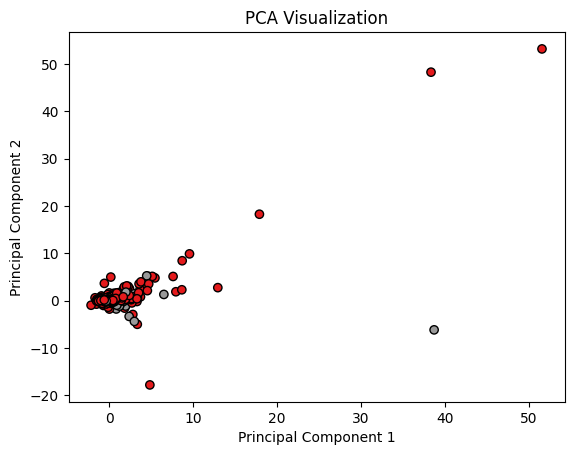

In [98]:
plot_pca_predict_2d(X_smote,X_test,y_smote,y_test,5)

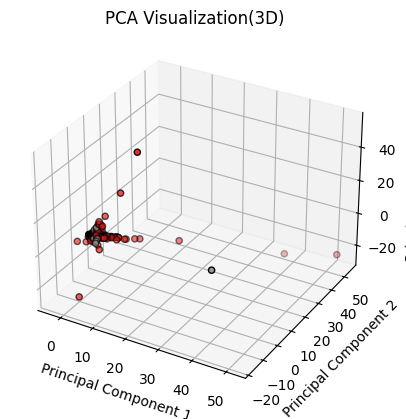

In [99]:
plot_pca_predict_3d(X_smote,X_test,y_smote,y_test,5)

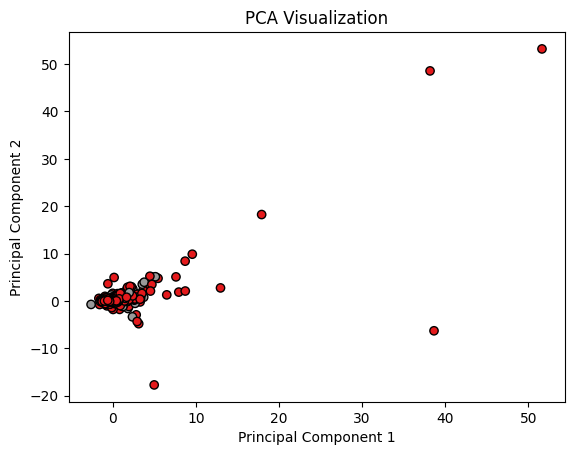

In [100]:
plot_predict_pca_2d(X_smote,X_test,y_smote,y_test,5)

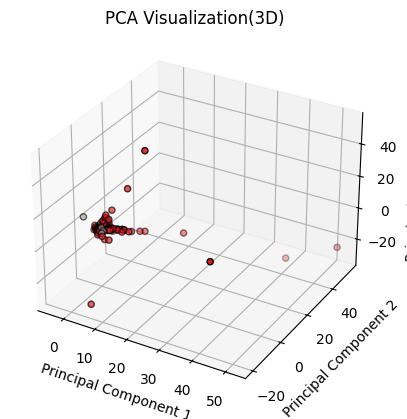

In [101]:
plot_predict_pca_3d(X_smote,X_test,y_smote,y_test,5)